# **One-time Init**

In [ ]:
from os import chdir, environ
environ['TZ'] = 'US/Central'
!nvidia-smi

Sat Jan  1 22:07:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0  On |                  N/A |
|  0%   51C    P5    16W / 170W |   4091MiB / 12288MiB |     34%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/google_drive', force_remount=True)
!unlink /content/drive
!ln -s /content/google_drive/MyDrive/ /content/drive

ModuleNotFoundError: ignored

In [ ]:
# For debug
from os import environ
# environ['CUDA_LAUNCH_BLOCKING'] = '1'

# **Starting Work**

In [1]:
from os import chdir, environ
environ['TZ'] = 'US/Central'
chdir('PointCloud/')
# chdir('/content/drive/PointCloud/')

In [2]:
global logging_init_flag
logging_init_flag = False

def init_logging(OUTPUT):
    global logging_init_flag
    if logging_init_flag:
        return
    logging_init_flag = True

    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    formatter = logging.Formatter(
        '%(asctime)s - %(levelname)s:\t%(message)s',
        datefmt='%Y-%m-%d %H:%M:%S')

    fh = logging.FileHandler(f"{OUTPUT}/training.log")
    fh.setLevel(logging.INFO)
    fh.setFormatter(formatter)

    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    ch.setFormatter(formatter)

    logger.addHandler(ch)
    logger.addHandler(fh)



In [3]:
!ls -lt --time-style='+%y-%m-%d %H:%M:%S'
!dir

'ls' is not recognized as an internal or external command,
operable program or batch file.


 Volume in drive C is OS
 Volume Serial Number is 3A4D-1115

 Directory of C:\Users\immor\colab\PointCloud

01/07/2022  02:46    <DIR>          .
01/06/2022  20:37    <DIR>          ..
10/27/2021  09:09            53,575 build_tree
11/01/2021  22:50             3,795 build_tree.cpp
01/05/2022  22:40            19,450 build_tree.py
11/01/2021  22:50             2,769 build_tree_basic.cpp
11/01/2021  22:50             5,065 build_tree_extra.cpp
10/24/2021  09:45             1,969 build_tree_toy.py
01/07/2022  02:46             8,160 dataset.py
12/03/2021  11:10    <DIR>          datasets
09/23/2021  13:13               208 def.sh
09/24/2021  10:16           579,198 dev.ans
10/27/2021  09:09           350,568 dev.out
01/07/2022  02:24            11,864 encoder.py
10/31/2021  11:26             9,195 model.py
10/17/2021  15:20            12,386 model_arrange.py
11/02/2021  20:28            14,641 model_attention.py
10/23/2021  06:33            14,284 model_carry.py
09/30/2021  21:57        

# **Experiment Init**

In [4]:
import json
import h5py
import torch
import os
# from encoder import Encoder, MLP
from encoder import Encoder, MLP
from build_tree import get_directions, init_directions
import logging
from dataset import *

# 1
# prefix = "_orig_pca_nosample_x2"
# no_prealign = True 
# rotate_only = False
# augment = 2 
# transform = no_transform 
# use_symmetry_loss = True
# dim = 2048 # 2048
# dim_layer0 = 16 # 16
# dim_repeat_cut = 5
# train_augment = False
# permute_augment = False

# 2
prefix = "_affine_pca_nosample_x16"
no_prealign = False 
rotate_only = False
augment = 16
transform = affine_transform 
use_symmetry_loss = False
dim = 2048 # 2048
dim_layer0 = 16 # 16
dim_repeat_cut = 5
train_augment = False
permute_augment = True

OUTPUT = 'scratch_extra'
model_size = 2 ** 11
sample_layers = 50 # 2
channel = 1


sample_child_first = False # True in l7s1
num_classes = 40
DATASET = './datasets/ModelNet40'
chaos_limit = 0

init_logging(OUTPUT)
logging.info(f"prefix = {prefix}")
_ = init_directions(chaos_limit, calc_dmap=False)


2022-01-07 14:13:17 - INFO:	prefix = _affine_pca_nosample_x16
2022-01-07 14:13:17 - INFO:	init_directions: # = 3
2022-01-07 14:13:17 - DEBUG:	0: 0.000000 1.000000 0.000000 otho = {1, 2}
2022-01-07 14:13:17 - DEBUG:	1: 1.000000 0.000000 0.000000 otho = {0, 2}
2022-01-07 14:13:17 - DEBUG:	2: 0.000000 0.000000 1.000000 otho = {0, 1}
2022-01-07 14:13:17 - INFO:	basic # = 3
2022-01-07 14:13:17 - INFO:	transforms # = 48


In [5]:
torch.manual_seed(674433238)
model = Encoder(model_size, sample_layers, dim, OUTPUT, channel=channel, sample_child_first=sample_child_first, dim_layer0=dim_layer0, dim_repeat_cut=dim_repeat_cut, use_symmetry_loss=use_symmetry_loss).cuda()
model.dim

2022-01-07 14:13:17 - INFO:	self.N = 2048
2022-01-07 14:13:17 - INFO:	self.num_layers = 12
2022-01-07 14:13:17 - INFO:	self.sample_layers = 50
2022-01-07 14:13:17 - INFO:	layer 0 (leaf) # = 2048 odim = 16
2022-01-07 14:13:18 - INFO:	layer 1 (unsampled) # = 1024 odim = 32
2022-01-07 14:13:18 - INFO:	layer 2 (unsampled) # = 512 odim = 64
2022-01-07 14:13:18 - INFO:	layer 3 (unsampled) # = 256 odim = 128
2022-01-07 14:13:18 - INFO:	layer 4 (unsampled) # = 128 odim = 256
2022-01-07 14:13:18 - INFO:	layer 5 (unsampled) # = 64 odim = 256
2022-01-07 14:13:18 - INFO:	layer 6 (unsampled) # = 32 odim = 512
2022-01-07 14:13:18 - INFO:	layer 7 (unsampled) # = 16 odim = 512
2022-01-07 14:13:18 - INFO:	layer 8 (unsampled) # = 8 odim = 1024
2022-01-07 14:13:18 - INFO:	layer 9 (unsampled) # = 4 odim = 1024
2022-01-07 14:13:18 - INFO:	layer 10 (unsampled) # = 2 odim = 2048
2022-01-07 14:13:18 - INFO:	layer 11 (unsampled) # = 1 odim = 2048


2048

In [6]:
model

Encoder(
  (layers): ModuleList(
    (0): EncoderLayer(
      (pts_align): Alignment(
        (conv1): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
        (conv3): Conv1d(256, 1024, kernel_size=(1,), stride=(1,))
        (fc1): Linear(in_features=1024, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (fc3): Linear(in_features=256, out_features=9, bias=True)
        (relu): ReLU()
        (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
     

# **Debug**

In [ ]:
assert False, "debug part cannot be run through"

AssertionError: ignored

In [7]:
pts = h5py.File(f'{DATASET}/train0.h5')['data'][0]
pts = torch.tensor(pts)
output = None

<ipython-input-7-17a3ae9dea0c>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  pts = h5py.File(f'{DATASET}/train0.h5')['data'][0]


In [10]:
pts = transform(pts)

In [8]:
tree = model.tree
pts, output, extra = model.tree.arrange(pts, rotate=not no_prealign, extra=False, pca=True,
                                          rotate_only=rotate_only, debug=True)

In [ ]:
%matplotlib inline
def plot(points, color_layers=2, output=None):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.gridspec as gridspec
    import numpy as np

    points = points.cpu().numpy()
    x, y, z = points[:,0], points[:,1], points[:,2]
    x -= x.mean()
    y -= y.mean()
    z -= z.mean()

    color = np.array([0 for _ in range(x.shape[0])])
    
    def mark_color(z, last_ind=None):
        n = z.shape[0]
        ind = torch.tensor(z).sort()[1].numpy()
        indl, indr = ind[: n >> 1], ind[n >> 1 : ]
        if last_ind is not None:
            indl, indr = last_ind[indl], last_ind[indr]
        color[indr] += 1
        return indl, indr

    if output is not None:

        color = torch.tensor([0]).cuda()
        # print(tree.layer_size)
        for i, (layer, next_layer_size) in enumerate(zip(reversed(model.layers[1:]), tree.layer_size[1:])):
            next_color = torch.zeros(next_layer_size).long().cuda()
            if i < color_layers:
                color = color << 1
                right_add = 1
            else:
                right_add = 0
            assert layer.child_l.max() < next_layer_size
            assert layer.child_r.max() < next_layer_size
            next_color[layer.child_l] = color
            next_color[layer.child_r] = color + right_add
            color = next_color

        arrange = output[0]
        n = points.shape[0]
        color = np.array([color[arrange == i].max().item() for i in range(n)])

    elif color_layers >= 1:
        l, r = mark_color(z)
        if color_layers >= 2:
            color *= 2
            ll, lr = mark_color(y[l], l)
            rl, rr = mark_color(y[r], r)
            if color_layers >= 3:
                color *= 2
                for p in [ll, lr, rl, rr]:
                    mark_color(x[p], p)

    colormap = np.array(['red', 'blue', 'green', 'yellow', 'grey', 'orange', 'purple', 'cyan'])

    fig = plt.figure(dpi=80)
    gs = gridspec.GridSpec(nrows=2, ncols=4, left=0.1, right=2.5, wspace=0.05, hspace=0.05, bottom=0.1, top=1.3)
    for i in range(8):
        ax = fig.add_subplot(gs[i // 4, i % 4], projection='3d')

        x, y, z = points[:,0], points[:,1], points[:,2]
        labx, laby, labz = 'x', 'y', 'z'
        if (i & 4) != 0:    x = -x; labx = '-x'
        if (i & 2) != 0:    y = -y; laby = '-y'
        if (i & 1) != 0:    z = -z; labz = '-z'

        lmin = min(x.min(), y.min(), z.min())
        lmax = max(x.max(), y.max(), z.max())
        ax.scatter(x, y, z, c=colormap[color], marker='.')

        ax.set_xlim(lmin, lmax)
        ax.set_ylim(lmin, lmax)
        ax.set_zlim(lmin, lmax)

        ax.set_xlabel(labx)
        ax.set_ylabel(laby)
        ax.set_zlabel(labz) 
    plt.show()

    fig = plt.figure(dpi=80)
    ncolor = color.max() + 1
    nrows = max(1, ncolor // 4)
    ncols = min(ncolor, 4)
    gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, left=0.1, right=0.1 + 0.6 * ncols, wspace=0.05, hspace=0.05, bottom=0.1, top=0.1 + 0.6 * nrows)
    for i in range(ncolor):
        ax = fig.add_subplot(gs[i // 4, i % 4], projection='3d')

        p = points[color == i]
        x, y, z = p[:,0], p[:,1], p[:,2]

        lmin = min(x.min(), y.min(), z.min())
        lmax = max(x.max(), y.max(), z.max())
        ax.scatter(x, y, z, c=colormap[i], marker='.')

        ax.set_xlim(lmin, lmax)
        ax.set_ylim(lmin, lmax)
        ax.set_zlim(lmin, lmax)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z') 
    plt.show()

2022-01-05 22:39:59 - DEBUG:	findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-01-05 22:39:59 - DEBUG:	findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
2022-01-05 22:39:59 - DEBUG:	findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
2022-01-05 22:39:59 - DEBUG:	findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
2022-01-05 22:39:59 - DEBUG:	findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2022-01-05 22:39:59 - DEBUG:	findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2022-01-05 22:39:59 - DEBUG:	findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2022-01-05 22:39:59 - DEBUG:	findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
2022-01-05 2

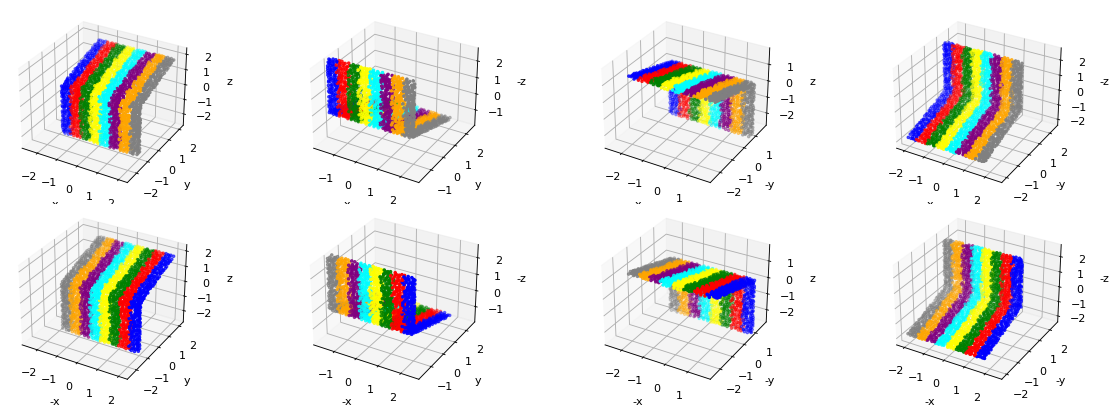

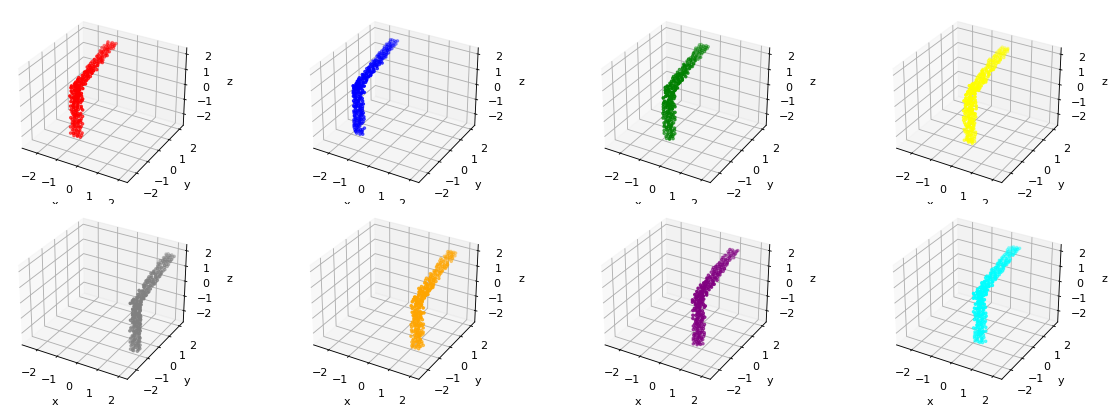

In [14]:
plot(pts, 3, output=output)

In [ ]:
batch_size = 64
model.train()
for _ in range(8):
    _pts = pts.unsqueeze(0).expand(batch_size, *pts.shape)
    _output = list(map(lambda x : x.unsqueeze(0).expand(batch_size, *x.shape), output))
    _extra = extra.unsqueeze(0).expand(batch_size, *extra.shape)
    feature = model(_pts, _output, _extra)
    print(feature.shape)
    (feature.sum()).backward()

torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])
torch.Size([64, 2048])


In [ ]:
plot_tri(pts, tri_ind)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_tri(points, tri):
    points = points.numpy()
    tri = tri.numpy()

    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111, projection='3d')
    
    edges = collect_edges(tri)
    x = np.array([])
    y = np.array([])
    z = np.array([])
    for (i,j) in edges:
        x = np.append(x, [points[i, 0], points[j, 0], np.nan])      
        y = np.append(y, [points[i, 1], points[j, 1], np.nan])      
        z = np.append(z, [points[i, 2], points[j, 2], np.nan])
    ax.plot3D(x, y, z, color='g', lw='0.1')

    ax.scatter(points[:,0], points[:,1], points[:,2], color='b', s=1)


def collect_edges(tri):
    edges = set()

    def sorted_tuple(a,b):
        return (a,b) if a < b else (b,a)
    # Add edges of tetrahedron (sorted so we don't add an edge twice, even if it comes in reverse order).
    for (i0, i1, i2, i3) in tri:
        edges.add(sorted_tuple(i0,i1))
        edges.add(sorted_tuple(i0,i2))
        edges.add(sorted_tuple(i0,i3))
        edges.add(sorted_tuple(i1,i2))
        edges.add(sorted_tuple(i1,i3))
        edges.add(sorted_tuple(i2,i3))
    return edges

In [ ]:
pts = train_data[7][0]
output = None

In [ ]:
for i in range(50):
    output, arrange = tree.arrange(pts, basic=basic, debug=False, device='cpu')

In [ ]:
feature.shape

In [ ]:
for i in range(10):
    loss = model(pts.unsqueeze(0), list(map(lambda x : x.unsqueeze(0), output))).view(-1).sum()
    loss.backward()

In [ ]:
model

In [ ]:
for name, param in model.named_parameters():
    print(name, param.size())

In [ ]:
for name, param in model.named_parameters():
    if 'activate' in name:
        print(name, "\t", param.item())

In [ ]:
!cp /tmp/cppinput.txt scratch/

In [ ]:
!tail -n 5 /tmp/cppoutput.txt

# **Data**

In [7]:
from dataset import *
import numpy as np

In [8]:
if False:
    from random import shuffle, seed
    raw_data = torch.load(f'{OUTPUT}/train_data{prefix}.pth')
    n = len(raw_data) // data_augments
    perm = list(range(n))
    seed(674433238)
    shuffle(perm)
    train_perm = perm[: -n//8]
    valid_perm = perm[-n//8: ]
    torch.save([train_perm, valid_perm], f'{OUTPUT}/train_split{prefix}.pth')

In [9]:
make = make_data_default
if rotate_only:
    make = make_data_rotate_only
if no_prealign:
    make = make_data_no_prealign

In [10]:
n_train = 5
clouds = []
labels = []
for i in range(n_train):
    data_file = h5py.File(f'{DATASET}/train{i}.h5')
    clouds.append(torch.tensor(np.array(data_file['data'])))
    labels.append(torch.tensor(np.array(data_file['label'])))

clouds = torch.cat(clouds, dim=0)
labels = torch.cat(labels, dim=0)

try:
    train_perm, valid_perm = torch.load(f'{OUTPUT}/train_split{prefix}.pth')
except:
    train_perm, valid_perm = torch.load(f'{OUTPUT}/train_split.pth')

from math import ceil
train_dataset = PointCloudDataset(clouds, labels, model.tree.arrange, augment=augment, transform=transform, make=make, subset=train_perm)
valid_dataset = PointCloudDataset(clouds, labels, model.tree.arrange, augment=max(1, (1 + int(ceil(augment/4) + 0.5) if augment <= 4 else augment // 4)), transform=transform, make=make, subset=valid_perm)

<ipython-input-10-d66ef4e5e104>:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data_file = h5py.File(f'{DATASET}/train{i}.h5')


In [11]:
n_test = 2
clouds = []
labels = []
for i in range(n_test):
    data_file = h5py.File(f'{DATASET}/test{i}.h5')
    clouds.append(torch.tensor(np.array(data_file['data'])))
    labels.append(torch.tensor(np.array(data_file['label'])))

clouds = torch.cat(clouds, dim=0)
labels = torch.cat(labels, dim=0)

test_dataset = PointCloudDataset(clouds, labels, model.tree.arrange, augment=1, make=make, transform=transform)

<ipython-input-11-936995772004>:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data_file = h5py.File(f'{DATASET}/test{i}.h5')


In [12]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(137792, 4924, 2468)

In [13]:
target = [] # ['train', 'valid', 'test']

import gc
gc.collect()

for name, dataset in zip(['train', 'valid', 'test'], [train_dataset, valid_dataset, test_dataset]):
    from tqdm import tqdm

    if name not in target:
        continue

    num_workers = 16
    batch_size = 8

    data_init = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=placeholder, pin_memory=False, drop_last=False)
    logging.info(f"Init {name}")

    mem = []

    def save():
        torch.save(mem, f'{OUTPUT}/{name}_data{prefix}.pth')
        # logging.info("Saved")

    for i, data in enumerate(tqdm(data_init)):
        mem += data
        # logging.debug(f"Init {name}: {i+1}/{len(data_init)}")

        if (i + 1) % (400 * max(1, augment//4)) == 0:
            save()
    
    save()
    logging.info("Done")

    del mem
    gc.collect()


# **Pretrain**

In [ ]:
assert False, "not implemented"

In [ ]:
class FeatureMap(torch.nn.Module):
    def __init__(self, dim):
        super(FeatureMap, self).__init__()
        self.relu = torch.nn.ReLU()

        self.linear1 = torch.nn.Linear(dim, dim // 2)
        self.bn1 = torch.nn.BatchNorm1d(dim // 2)

        self.linear2 = torch.nn.Linear(dim // 2, dim // 4)
        self.bn2 = torch.nn.BatchNorm1d(dim // 4)

        self.linear3 = torch.nn.Linear(dim // 4, dim // 8)
        self.bn3 = torch.nn.BatchNorm1d(dim // 8)
        self.dropout = torch.nn.Dropout(0.7)

    def forward(self, ans):
        ans = self.linear1(ans)
        ans = self.bn1(ans)
        ans = self.relu(ans)

        ans = self.linear2(ans)
        ans = self.dropout(ans)
        ans = self.bn2(ans)
        ans = self.relu(ans)
        
        ans = self.linear3(ans)
        ans = self.bn3(ans)
        return ans

torch.manual_seed(674433238)
feature_map = FeatureMap(dim).cuda()

In [ ]:
try:
    raw_data
except:
    raw_data = torch.load(f'{OUTPUT}/train_data{prefix}.pth')
try:
    test_data
except:
    test_data = torch.load(f'{OUTPUT}/test_data{prefix}.pth')
try:
    train_perm, valid_perm = torch.load(f'{OUTPUT}/train_split{prefix}.pth')
except:
    train_perm, valid_perm = torch.load(f'{OUTPUT}/train_split.pth')

n = len(raw_data)

train_data = [raw_data[i * data_augments + j] for i in train_perm for j in range(data_augments)]
valid_data = [raw_data[i * data_augments + j] for i in valid_perm for j in range(data_augments)]

classes = [[] for i in range(num_classes)]
for (pts, output, extra, label) in train_data:
    classes[label.item()].append((pts, output, extra, label))

valid_classes = [[] for i in range(num_classes)]
for (pts, output, extra, label) in valid_data:
    valid_classes[label.item()].append((pts, output, extra, label))

from random import shuffle, seed
seed(674433238)
shuffle(train_data)
shuffle(valid_data)
shuffle(test_data)

In [ ]:
def make_batch(batches, eval=False):
    from random import randint
    layers = 0
    points = []
    inputs = None
    labels = []
    extras = []
    for pts, output, extra, label in batches:
        # Simple data augment
        # sgn = torch.tensor(-1).pow(torch.randint(low=0, high=2, size=[extra.shape[-1]])).cuda()
        sgn = (-1) ** randint(0, 1)
        
        points.append(pts.cuda())
        labels.append(label.cuda())
        extras.append(extra.cuda() * (1 if eval else sgn))
        if inputs is None:
            layers = len(output)
            inputs = [[] for _ in output]

        for line, out in zip(inputs, output):
            line.append(out.cuda())

    points = torch.stack(points, dim=0).float().cuda()
    extras = torch.stack(extras, dim=0).float().cuda()
    for i, line in enumerate(inputs):
        inputs[i] = torch.stack(line, dim=0).long().cuda()
    labels = torch.stack(labels, dim=0).long().cuda()
    
    return (points, inputs, extras), labels

In [ ]:
from random import choice
num_samples = 2
temperature = 0.07

class_size = torch.tensor([len(c) for c in classes]).float().cuda()
contrast_crit = torch.nn.CrossEntropyLoss(reduce=None)

def contrast_batch(used_classes=classes):
    batches = []
    for _ in range(num_samples):
        for c in used_classes:
            batches.append(choice(c))
    return make_batch(batches)

def contrast_loss(features, labels):
    num_data = num_classes * num_samples

    ratio = class_size[labels]
    ratio /= ratio.sum()
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1))

    features = torch.nn.functional.normalize(features, dim=1)

    sim = features.matmul(features.T)

    mask = torch.eye(num_data).bool().cuda()
    labels = labels[~mask].view(num_data, -1)
    sim = sim[~mask].view(num_data, -1)

    pos = sim[labels].view(num_data, -1)
    neg = sim[~labels].view(num_data, -1)

    logits = torch.cat([pos, neg], dim=1) / temperature

    correct = ((logits.argmax(dim=-1) == 0) * ratio).sum().item() * num_data

    loss = (contrast_crit(logits, torch.zeros(num_data).long().cuda()) * ratio).sum()

    return loss, correct

def valid_eval(classes=valid_classes):
    model.eval()
    feature_map.eval()

    with torch.no_grad():

        cum_loss = 0
        cum_correct = 0
        cum_1 = 0

        for _ in range(8):
            input, labels = contrast_batch(classes)
            features = feature_map(model(*input))
            l, c = contrast_loss(features, labels)

            cum_loss += l.item()
            cum_correct += c / (num_classes * num_samples)
            cum_1 += 1

        valid_str = "valid = %.4lf (%.6lf)" % (cum_loss / cum_1, cum_correct / cum_1)

    model.train()
    feature_map.train()

    return valid_str


In [ ]:
from random import choice, randint, seed
import build_tree
import torch
from math import sin, acos

logging.info(f"train_data # = {len(train_data)}")


model.train()
feature_map.train()
activate = lambda x : x

pi = acos(-1)
cum_loss = 0

batch_scale = 1 # 1 if basic else 1
epoch_scale = 4 # 4 if basic else 2
num_trans = 1

print_epoch = 50
valid_epoch = 1
epoch_since = 0
save_epoch = 500
cut_epoch = 10000000000
correct = 0
total = 0

debug_print = 5

def erate_value(epoch):
    N = 20000
    return torch.tensor(sin(min(1, epoch / N) * pi / 2)).cuda()

threshold = -1.0

num_epoch = 100000

crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(list(model.parameters()) + list(feature_map.parameters()), lr=1e-4)
# sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epoch / 5, eta_min=1e-5)
sch = torch.optim.lr_scheduler.ExponentialLR(opt, 0.9999)

def get_trans(n=3):
    if n == 0:  return [None]
    return [randint(0, len(build_tree.transforms) - 1) for _ in range(n)]

In [ ]:
seed(674433238)
torch.manual_seed(674433238)

best_vres = -1.0

for epoch in range(1, num_epoch + 1):
    for _ in range(epoch_scale):
        loss = 0.
        for _ in range(batch_scale):
            input, labels = contrast_batch()
            for iperm in get_trans(num_trans):

                features = feature_map(model(*input, perm=iperm))
                l, c = contrast_loss(features, labels)
                loss += l

                with torch.no_grad():
                    correct += c
                    total += labels.shape[0]
                    epoch_since += 1
        
        # assert loss.isnan().sum() == 0
        cum_loss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    sch.step()
        
    if epoch <= debug_print or epoch % print_epoch == 0:
        valid_str = ""
        func = logging.debug
        func(f"train #{epoch} lr = {'%.2e' % sch.get_last_lr()[0]} train = {'%.4lf (%.6lf)' % (cum_loss / epoch_since, correct / total)} {valid_eval()}")
        epoch_since = cum_loss = correct = total = 0

    if epoch % save_epoch == 0 or epoch == debug_print:
        torch.save({
            'encoder': model.state_dict(),
            'feature_map': feature_map.state_dict(),
        }, f"{OUTPUT}/pretrained_{epoch}.pth")
        logging.info(f"Saved")

# **Train**

In [14]:
from dataset import make_batch_train, make_batch_eval

global batch_size
num_workers = 0
batch_size = 64

for name, dataset in zip(['train', 'valid', 'test'], [train_dataset, valid_dataset, test_dataset]):
    print(f"Loading {name}")
    dataset.mem = torch.load(f'{OUTPUT}/{name}_data{prefix}.pth')
    assert len(dataset.mem) == len(dataset)

mbtrain = make_batch_train # make_batch_generator(dropout=0.5, augment=train_augment)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=mbtrain, pin_memory=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=make_batch_eval, pin_memory=True, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=make_batch_eval, pin_memory=True, drop_last=False)

Loading train
Loading valid
Loading test


In [15]:
torch.manual_seed(674433238)

if 'orig' in prefix:
    class Classifier(torch.nn.Module):
        def __init__(self, idim, odim):
            super(Classifier, self).__init__()
            self.relu = torch.nn.ReLU()

            self.linear1 = torch.nn.Linear(idim, idim // 2)
            self.bn1 = torch.nn.BatchNorm1d(idim // 2)

            self.linear2 = torch.nn.Linear(idim // 2, idim // 4)
            self.bn2 = torch.nn.BatchNorm1d(idim // 4)
            self.dropout = torch.nn.Dropout(1 - 1/8)

            self.linear3 = torch.nn.Linear(idim // 4, odim)

        def forward(self, ans):
            ans = self.linear1(ans)
            ans = self.bn1(ans)
            ans = self.relu(ans)

            ans = self.linear2(ans)
            ans = self.bn2(ans)
            ans = self.dropout(ans)
            ans = self.relu(ans)
            
            ans = self.linear3(ans)
            return ans
    linear = Classifier(model.dim, num_classes).cuda()
else:
    linear = MLP([model.dim, model.dim // 2, model.dim // 4, num_classes], last_bn=False).cuda()

linear

MLP(
  (layers): ModuleList(
    (0): FC(
      (linear): Linear(in_features=2048, out_features=1024, bias=True)
      (relu): PReLU(num_parameters=1)
      (batch_norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): FC(
      (linear): Linear(in_features=1024, out_features=512, bias=True)
      (relu): PReLU(num_parameters=1)
      (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): FC(
      (linear): Linear(in_features=512, out_features=40, bias=True)
    )
  )
)

In [16]:
def evaluate(model, linear, loader, noprint=False, perms=[None]):
    correct = 0
    total = 0

    if not noprint:
        logging.info(f"loader # = {len(loader)}")

    print_epoch = 1

    model.eval()
    linear.eval()
    activate = lambda x : x

    for epoch, (input, label) in enumerate(loader):
        with torch.no_grad():
            label = label.squeeze(-1).cuda()
            for perm in perms:
                result = activate(linear(model(*input, perm=perm).contiguous().view(label.size(0), -1)))

                correct += (result.argmax(dim=-1) == label.cuda()).sum().item()
                total += label.size()[0]

        if not noprint:
            if (epoch // batch_size + 1) % print_epoch == 0:
                logging.debug(f"test #{epoch} correct = {'%.6lf' % (correct / total)}")

    if not noprint:
        logging.info(f"Done: score = {'%.8lf' % (correct / total)}")

    model.train()
    linear.train()  
    
    return correct / total

In [17]:
from random import choice, randint
import build_tree
import torch

def get_trans(n=3):
    if n == 0:  return [None]
    return [randint(0, len(build_tree.transforms) - 1) for _ in range(n)]

def save(epoch):
    torch.save({
        'encoder': model.state_dict(),
        'linear': linear.state_dict(),
        # 'opt': opt.state_dict(),
        # 'sch': sch.state_dict(),
        # 'best_vres': best_vres,
    }, f"{OUTPUT}/trained_{epoch}.pth")

In [18]:
# if 'orig' in prefix:
#     ckpt = torch.load(f"{OUTPUT}/pretrained_affine_pca_nosample_x16_20211207.pth")
#     model.load_state_dict(ckpt['encoder'])
#     linear.load_state_dict(ckpt['linear'])
#     print("Pretrain loaded")

In [19]:
global current_epoch
global best_vres
current_epoch = 0
best_vres = -1.0

def train(more_epoch=100000, valid_result_threshold=1.0):
    global current_epoch
    global best_vres
    global batch_size

    logging.info(f"train epoch = {current_epoch + 1} ~ {more_epoch} threshold = {valid_result_threshold}")

    model.train()
    linear.train()
    activate = lambda x : x

    cum_loss = 0

    batch_scale = 1 # 1 if basic else 1
    epoch_scale = 8 # 4 if basic else 2
    num_trans = 1 if permute_augment else 0


    print_epoch = 20
    valid_epoch = 20
    epoch_since = 0
    save_epoch = 100
    cut_epoch = 10000000000
    correct = 0
    total = 0

    temperature = 1
    threshold = -1.0

    crit = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(list(model.parameters()) + list(linear.parameters()), lr=1e-4)
    sch = torch.optim.lr_scheduler.ExponentialLR(opt, 0.9999)
    save(current_epoch)

    for epoch in range(current_epoch + 1, current_epoch + more_epoch + 1):

        current_epoch = epoch

        for _ in range(epoch_scale):
            loss = 0.
            for _ in range(batch_scale):
                input, label = next(iter(train_loader))
                label = label.squeeze(-1).cuda()
                for iperm in get_trans(num_trans):
                    
                    logits = linear(model(*input, perm=iperm).contiguous().view(batch_size, -1))
                    loss += crit(logits / temperature, label.cuda())

                    with torch.no_grad():
                        correct += (logits.argmax(dim=-1) == label.cuda()).sum().item()
                        total += label.size()[0]
                        epoch_since += 1
            
            # assert loss.isnan().sum() == 0
            cum_loss += loss.item()
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        sch.step()

        if cum_loss / epoch_since < threshold:
            epoch_scale, batch_scale = batch_scale, epoch_scale
            
            logging.info("Threshold Reached")
            threshold = -1e10
            
        if epoch <= 5 or epoch % print_epoch == 0:
            valid_str = ""
            func = logging.debug

            stop_training = False
            if epoch % valid_epoch == 0:
                vres = evaluate(model, linear, valid_loader, noprint=True)
                valid_str = f"valid = {'%.6lf' % vres}"
                stop_training = (vres >= valid_result_threshold)
                if vres > best_vres:
                    best_vres = vres
                    torch.save({
                        'encoder': model.state_dict(),
                        'linear': linear.state_dict()
                    }, f"{OUTPUT}/trained_best{prefix}.pth")
                    valid_str += " updated"

                func = logging.info
            func(f"train #{epoch} lr = {'%.2e' % sch.get_last_lr()[0]} loss = {'%.6lf' % (cum_loss / epoch_since)} train = {'%.6lf' % (correct / total)} {valid_str}")
            epoch_since = cum_loss = correct = total = 0

            if stop_training:
                break


        if epoch % save_epoch == 0:
            save(epoch)
            tres = evaluate(model, linear, test_loader, noprint=True)
            logging.info(f"Saved test = {'%.6lf' % tres}")

        if epoch % cut_epoch == 0:
            if batch_size > 8:
                batch_size //= 2
                epoch_scale *= 2

            logging.info(f"Cut batch_size = {batch_size} epoch_scale = {epoch_scale}")

In [ ]:
train()

2022-01-07 14:14:07 - INFO:	train epoch = 1 ~ 100000 threshold = 1.0
2022-01-07 14:14:11 - DEBUG:	train #1 lr = 1.00e-04 loss = 3.593763 train = 0.083984 
2022-01-07 14:14:12 - DEBUG:	train #2 lr = 1.00e-04 loss = 3.177382 train = 0.195312 
2022-01-07 14:14:13 - DEBUG:	train #3 lr = 1.00e-04 loss = 2.970898 train = 0.224609 
2022-01-07 14:14:13 - DEBUG:	train #4 lr = 1.00e-04 loss = 2.812250 train = 0.269531 
2022-01-07 14:14:14 - DEBUG:	train #5 lr = 1.00e-04 loss = 2.758299 train = 0.263672 
2022-01-07 14:14:30 - INFO:	train #20 lr = 9.98e-05 loss = 2.513334 train = 0.334505 valid = 0.374289 updated
2022-01-07 14:14:49 - INFO:	train #40 lr = 9.96e-05 loss = 2.080728 train = 0.435645 valid = 0.428920 updated


# **Train Result Archive**

In [ ]:
assert False, "protected"

In [ ]:
# affined
train()

2021-12-07 12:40:06 - INFO:	train epoch = 1 ~ 100000 threshold = 1.0
2021-12-07 12:40:13 - DEBUG:	train #1 lr = 1.00e-04 loss = 3.532099 train = 0.113281 
2021-12-07 12:40:14 - DEBUG:	train #2 lr = 1.00e-04 loss = 3.136032 train = 0.207031 
2021-12-07 12:40:14 - DEBUG:	train #3 lr = 1.00e-04 loss = 2.982427 train = 0.230469 
2021-12-07 12:40:15 - DEBUG:	train #4 lr = 1.00e-04 loss = 2.849443 train = 0.246094 
2021-12-07 12:40:16 - DEBUG:	train #5 lr = 1.00e-04 loss = 2.799874 train = 0.265625 
2021-12-07 12:40:48 - INFO:	train #20 lr = 9.98e-05 loss = 2.527639 train = 0.329167 valid = 0.301584 updated
2021-12-07 12:41:23 - INFO:	train #40 lr = 9.96e-05 loss = 2.075174 train = 0.431348 valid = 0.443745 updated
2021-12-07 12:41:46 - INFO:	train #60 lr = 9.94e-05 loss = 1.801864 train = 0.500684 valid = 0.487612 updated
2021-12-07 12:42:21 - INFO:	train #80 lr = 9.92e-05 loss = 1.616541 train = 0.543457 valid = 0.492080 updated
2021-12-07 12:42:52 - INFO:	train #100 lr = 9.90e-05 loss = 1

KeyboardInterrupt: ignored

In [20]:
# orig, dropout=1-1/8, make_batch dropout=0.5
train()

2022-01-07 02:46:42 - INFO:	train epoch = 1 ~ 100000 threshold = 1.0
2022-01-07 02:46:45 - DEBUG:	train #1 lr = 1.00e-04 loss = 3.779135 train = 0.066406 
2022-01-07 02:46:46 - DEBUG:	train #2 lr = 1.00e-04 loss = 3.429246 train = 0.148438 
2022-01-07 02:46:47 - DEBUG:	train #3 lr = 1.00e-04 loss = 2.988290 train = 0.273438 
2022-01-07 02:46:48 - DEBUG:	train #4 lr = 1.00e-04 loss = 2.753161 train = 0.328125 
2022-01-07 02:46:49 - DEBUG:	train #5 lr = 1.00e-04 loss = 2.628055 train = 0.369141 
2022-01-07 02:47:02 - INFO:	train #20 lr = 9.98e-05 loss = 2.063089 train = 0.514323 valid = 0.625102 updated
2022-01-07 02:47:19 - INFO:	train #40 lr = 9.96e-05 loss = 1.553672 train = 0.625391 valid = 0.706336 updated
2022-01-07 02:47:37 - INFO:	train #60 lr = 9.94e-05 loss = 1.244488 train = 0.694434 valid = 0.757514 updated
2022-01-07 02:47:55 - INFO:	train #80 lr = 9.92e-05 loss = 1.087879 train = 0.733691 valid = 0.781885 updated
2022-01-07 02:48:12 - INFO:	train #100 lr = 9.90e-05 loss = 0

KeyboardInterrupt: ignored

# **Test**

In [ ]:
from dataset import make_batch_train, make_batch_eval

global batch_size
num_workers = 0
batch_size = 64

for name, dataset in zip(['valid', 'test'], [train_dataset, valid_dataset, test_dataset]):
    dataset.mem = torch.load(f'{OUTPUT}/{name}_data{prefix}.pth')

mbtrain = make_batch_train
# mbtrain = make_batch_train_augment

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=mbtrain, pin_memory=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=make_batch_eval, pin_memory=True, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=make_batch_eval, pin_memory=True, drop_last=False)

In [21]:
ckpt = torch.load(f"{OUTPUT}/trained_best{prefix}.pth")
# ckpt = torch.load(f"{OUTPUT}/trained_14000.pth")
model.load_state_dict(ckpt['encoder'])
linear.load_state_dict(ckpt['linear'])
batch_size = 64

In [22]:
evaluate(model, linear, valid_loader)

2022-01-07 11:32:58 - INFO:	loader # = 39
2022-01-07 11:32:58 - DEBUG:	test #0 correct = 0.875000
2022-01-07 11:32:58 - DEBUG:	test #1 correct = 0.875000
2022-01-07 11:32:58 - DEBUG:	test #2 correct = 0.875000
2022-01-07 11:32:58 - DEBUG:	test #3 correct = 0.882812
2022-01-07 11:32:58 - DEBUG:	test #4 correct = 0.881250
2022-01-07 11:32:58 - DEBUG:	test #5 correct = 0.877604
2022-01-07 11:32:58 - DEBUG:	test #6 correct = 0.877232
2022-01-07 11:32:59 - DEBUG:	test #7 correct = 0.869141
2022-01-07 11:32:59 - DEBUG:	test #8 correct = 0.864583
2022-01-07 11:32:59 - DEBUG:	test #9 correct = 0.867188
2022-01-07 11:32:59 - DEBUG:	test #10 correct = 0.872159
2022-01-07 11:32:59 - DEBUG:	test #11 correct = 0.876302
2022-01-07 11:32:59 - DEBUG:	test #12 correct = 0.879808
2022-01-07 11:32:59 - DEBUG:	test #13 correct = 0.878348
2022-01-07 11:32:59 - DEBUG:	test #14 correct = 0.877083
2022-01-07 11:32:59 - DEBUG:	test #15 correct = 0.878906
2022-01-07 11:32:59 - DEBUG:	test #16 correct = 0.881434

0.8862713241267263

In [23]:
evaluate(model, linear, test_loader)

2022-01-07 11:33:02 - INFO:	loader # = 39
2022-01-07 11:33:02 - DEBUG:	test #0 correct = 0.781250
2022-01-07 11:33:02 - DEBUG:	test #1 correct = 0.789062
2022-01-07 11:33:02 - DEBUG:	test #2 correct = 0.807292
2022-01-07 11:33:02 - DEBUG:	test #3 correct = 0.839844
2022-01-07 11:33:02 - DEBUG:	test #4 correct = 0.840625
2022-01-07 11:33:02 - DEBUG:	test #5 correct = 0.841146
2022-01-07 11:33:02 - DEBUG:	test #6 correct = 0.845982
2022-01-07 11:33:02 - DEBUG:	test #7 correct = 0.857422
2022-01-07 11:33:02 - DEBUG:	test #8 correct = 0.857639
2022-01-07 11:33:02 - DEBUG:	test #9 correct = 0.859375
2022-01-07 11:33:02 - DEBUG:	test #10 correct = 0.866477
2022-01-07 11:33:02 - DEBUG:	test #11 correct = 0.869792
2022-01-07 11:33:03 - DEBUG:	test #12 correct = 0.872596
2022-01-07 11:33:03 - DEBUG:	test #13 correct = 0.869420
2022-01-07 11:33:03 - DEBUG:	test #14 correct = 0.868750
2022-01-07 11:33:03 - DEBUG:	test #15 correct = 0.866211
2022-01-07 11:33:03 - DEBUG:	test #16 correct = 0.861213

0.8476499189627229

In [ ]:
evaluate(model, linear, train_loader)

2021-11-29 22:03:37 - INFO:	loader # = 1076
2021-11-29 22:03:37 - DEBUG:	test #0 correct = 1.000000
2021-11-29 22:03:37 - DEBUG:	test #1 correct = 1.000000
2021-11-29 22:03:37 - DEBUG:	test #2 correct = 1.000000
2021-11-29 22:03:37 - DEBUG:	test #3 correct = 1.000000
2021-11-29 22:03:37 - DEBUG:	test #4 correct = 1.000000
2021-11-29 22:03:37 - DEBUG:	test #5 correct = 0.997396
2021-11-29 22:03:37 - DEBUG:	test #6 correct = 0.997768
2021-11-29 22:03:38 - DEBUG:	test #7 correct = 0.998047
2021-11-29 22:03:38 - DEBUG:	test #8 correct = 0.998264
2021-11-29 22:03:38 - DEBUG:	test #9 correct = 0.998437
2021-11-29 22:03:38 - DEBUG:	test #10 correct = 0.998580
2021-11-29 22:03:38 - DEBUG:	test #11 correct = 0.998698
2021-11-29 22:03:38 - DEBUG:	test #12 correct = 0.998798
2021-11-29 22:03:38 - DEBUG:	test #13 correct = 0.998884
2021-11-29 22:03:38 - DEBUG:	test #14 correct = 0.998958
2021-11-29 22:03:38 - DEBUG:	test #15 correct = 0.999023
2021-11-29 22:03:38 - DEBUG:	test #16 correct = 0.9990

KeyboardInterrupt: ignored

# **Scratch**

In [ ]:
for name, param in model.named_parameters():
    if 'srate' in name:
        print(name, param.item())